# augmentation을 적용한 함수 dl모델을 제작

기존의 resnet34에서 더욱 다양한 모델을 적용해봄
- resnet50
- efficientnet
- efficientnetv2
- ....

In [1]:
# wandb 연결
import wandb

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wpdn0134 (je_). Use `wandb login --relogin` to force relogin


True

In [3]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import cv2
import matplotlib.pyplot as plt

from itertools import combinations

In [4]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [6]:
wandb.init(
    # Set the project where this run will be logged
    project="cv_project",
    # Track hyperparameters and run metadata
    # config={
    #     "learning_rate": 0.01,
    #     "epochs": 50,
    # },
)
wandb.run.name = 'data_augmentation10'
wandb.run.save()

True

In [21]:
timm.list_models('resnet*')

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [22]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../datasets_fin/'

# model config
model_name = 'resnet50' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 256
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

In [8]:
# wandb에 저장할 요소
args = {
    'learning_rate' : LR,
    'epochs': EPOCHS,
    'batch_size' : BATCH_SIZE
}
wandb.config.update(args)

In [9]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    

In [10]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, vaild_loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    vaild_preds_list = []
    vaild_target_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.float().to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # vaildation set predict
    model.eval()
    for image, target in tqdm(vaild_loader):
        image = image.float().to(device)

        with torch.no_grad():
            preds = model(image)
        vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        vaild_target_list.extend(target.detach().cpu().numpy())
    vaild_acc = accuracy_score(vaild_target_list, vaild_preds_list)
    vaild_f1 = f1_score(vaild_target_list, vaild_preds_list, average='macro')

    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1" : vaild_f1,
    })

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1": vaild_f1,
    }

    return ret

In [11]:
# vaild_preds_list = []
# vaild_target_list = []

# model.eval()
# for image, target in tqdm(vaild_loader):
#     image = image.float().to(device)

#     with torch.no_grad():
#         preds = model(image)
#     vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
#     vaild_target_list.extend(target.detach().cpu().numpy())
# vaild_acc = accuracy_score(vaild_target_list, preds_list)
# vaild_f1 = f1_score(vaild_target_list, preds_list, average='macro')

- 일단 단일 augmentation들로 확인
- 성능향상시 다양한 데이터증강을 조합하여 추가학습

In [12]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])
# trn_transform_coarseDropout = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate45 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate90 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate135 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate180 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate225 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate270 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate315 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_verticalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.VerticalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_horizontalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.HorizontalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_blur = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Blur(always_apply=True, p=1.0, blur_limit=(3, 3)),
#     ToTensorV2(),
# ])
# trn_transform_gaussnoise = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.GaussNoise(always_apply=False, p=1.0, var_limit=(500.0, 500.0)),
#     ToTensorV2(),
# ])
# trn_transform_downscale = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Downscale(always_apply=False, p=1.0, scale_min=0.5, scale_max=0.5, interpolation=0),
#     ToTensorV2(),
# ])
# transform_list = [trn_transform, trn_transform_coarseDropout, trn_transform_rotate45, trn_transform_rotate90, trn_transform_rotate135, trn_transform_rotate180, trn_transform_rotate225,
#                   trn_transform_rotate270, trn_transform_rotate315, trn_transform_verticalflip, trn_transform_horizontalflip, trn_transform_blur, trn_transform_gaussnoise,
#                   trn_transform_downscale]

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [15]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.CenterCrop( 224 , 224 , always_apply = False , p = 1.0 ),
    # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
    ToTensorV2()
])
transform_list = [A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
                #   A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                #   A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(0, 360), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.VerticalFlip(always_apply=False, p=1),
                  A.HorizontalFlip(always_apply=False, p=1),
                #   A.Blur(always_apply=True, p=1, blur_limit=(3, 3)),
                  A.GaussNoise(always_apply=False, p=1, var_limit=(0.2, 0.2)),
                  A.Downscale(always_apply=False, p=1, scale_min=0.5, scale_max=0.5, interpolation=0),
                  A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                  A.RandomGridShuffle( grid = (3 , 3) , always_apply = False , p = 1 ),
                  A.RandomBrightness( limit = 0.2 , always_apply = False , p = 1 ),
                  A.GaussianBlur( blur_limit = (3,7) , always_apply = False , p = 1 ),
                  A.ToGray( always_apply = False , p = 1 ),
                #   A.CenterCrop( 224 , 224 , always_apply = False , p = 1.0 ),
                #   A.RandomCrop(224, 224, always_apply=False, p=1.0)
                  ]

tst_transform = A.Compose([ 
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
    ToTensorV2()
])

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [13]:
# transform_list에서 2개 조합으로 데이터 증강
for a, b in combinations(transform_list, 2):
    print(a, b, end="\n")

CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(45, 45), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(90, 90), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(135, 135), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropo

In [13]:
# Dataset 정의를 위한 함수
def make_dataset(transform_list, csv, path):
    trn_dataset = ImageDataset(
        csv,
        path,
        # transform=transform_list[0]
        transform = trn_transform
    )
    for transform in transform_list:
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                transform,
                A.RandomCrop(224, 224, always_apply=False, p=1.0),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

    for transform1, transform2 in combinations(transform_list, 2):
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                
                transform1,
                transform2,
                A.RandomCrop(224, 224, always_apply=False, p=1.0),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])


    return trn_dataset

In [12]:
# # vaildation set 정의
# def make_vaild_dataset(transform_list, csv, path):
#     trn_dataset = ImageDataset(
#         csv,
#         path,
#         transform=transform_list[0]
#     )
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform_list[0],
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])
    
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform,
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

#     for transform1, transform2 in combinations(transform_list, 2):
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform1,
#                 transform2,
#                 ToTensorV2()
#             ])
#         )

#     return trn_dataset

In [16]:
trn_dataset = make_dataset(transform_list, "../datasets_fin/divided_train.csv", "../datasets_fin/train/")
vaild_dataset = make_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/",)
tst_dataset = ImageDataset(
    "../datasets_fin/test.csv",
    "../datasets_fin/train/",
    transform=tst_transform
)
print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

84152 10519 157


In [23]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
vaild_loader = DataLoader(
    vaild_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [24]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [25]:
early_stop = 0
best_model = model
best_epoch = 0
best_vaild_f1 = 0
resent_model = model
before_vaild_f1 = 0
for epoch in range(EPOCHS):
   
   ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
   ret['epoch'] = epoch
   if before_vaild_f1 < ret['vaild_f1']:
      if best_vaild_f1 < ret['vaild_f1']:
         best_vaild_f1 = ret['vaild_f1']
         best_model = model
         best_epoch = epoch+1
      resent_model = model
      early_stop = 0
   else:
      early_stop += 1
   before_vaild_f1 = ret['vaild_f1']

   print(early_stop)

   log = ""
   for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
   print(log)

   if early_stop >= 2: # earlystop없이 모든 애폭을 사용하여 학습, 단 best model을 따로 저장
      torch.save(best_model, '../model/best_augmentation9_'+str(img_size)+'_'+str(best_epoch)+'.pt')
      break

100%|██████████| 329/329 [01:42<00:00,  3.22it/s]


0
train_loss: 0.1629
train_acc: 0.9453
train_f1: 0.9424
vaild_acc: 0.8883
vaild_f1: 0.8818
epoch: 0.0000



100%|██████████| 329/329 [01:42<00:00,  3.20it/s]


0
train_loss: 0.0382
train_acc: 0.9873
train_f1: 0.9866
vaild_acc: 0.8993
vaild_f1: 0.8969
epoch: 1.0000



100%|██████████| 329/329 [01:42<00:00,  3.22it/s]


1
train_loss: 0.0278
train_acc: 0.9908
train_f1: 0.9902
vaild_acc: 0.8822
vaild_f1: 0.8819
epoch: 2.0000



100%|██████████| 329/329 [01:42<00:00,  3.20it/s]


0
train_loss: 0.0216
train_acc: 0.9927
train_f1: 0.9923
vaild_acc: 0.9005
vaild_f1: 0.8952
epoch: 3.0000



100%|██████████| 329/329 [01:43<00:00,  3.19it/s]


1
train_loss: 0.0179
train_acc: 0.9940
train_f1: 0.9937
vaild_acc: 0.8943
vaild_f1: 0.8879
epoch: 4.0000



100%|██████████| 329/329 [01:43<00:00,  3.19it/s]


0
train_loss: 0.0147
train_acc: 0.9951
train_f1: 0.9949
vaild_acc: 0.8986
vaild_f1: 0.8915
epoch: 5.0000



100%|██████████| 329/329 [01:42<00:00,  3.20it/s]


1
train_loss: 0.0147
train_acc: 0.9953
train_f1: 0.9950
vaild_acc: 0.8976
vaild_f1: 0.8909
epoch: 6.0000



100%|██████████| 329/329 [01:41<00:00,  3.24it/s]


0
train_loss: 0.0108
train_acc: 0.9966
train_f1: 0.9964
vaild_acc: 0.8977
vaild_f1: 0.8927
epoch: 7.0000



100%|██████████| 329/329 [01:42<00:00,  3.22it/s]


0
train_loss: 0.0108
train_acc: 0.9964
train_f1: 0.9963
vaild_acc: 0.8969
vaild_f1: 0.8957
epoch: 8.0000



100%|██████████| 329/329 [01:41<00:00,  3.24it/s]


0
train_loss: 0.0097
train_acc: 0.9968
train_f1: 0.9966
vaild_acc: 0.9065
vaild_f1: 0.9010
epoch: 9.0000



100%|██████████| 329/329 [01:41<00:00,  3.23it/s]


1
train_loss: 0.0090
train_acc: 0.9971
train_f1: 0.9969
vaild_acc: 0.8958
vaild_f1: 0.8863
epoch: 10.0000



100%|██████████| 329/329 [01:40<00:00,  3.28it/s]


0
train_loss: 0.0083
train_acc: 0.9972
train_f1: 0.9970
vaild_acc: 0.9034
vaild_f1: 0.9001
epoch: 11.0000



100%|██████████| 329/329 [01:39<00:00,  3.30it/s]


0
train_loss: 0.0079
train_acc: 0.9974
train_f1: 0.9973
vaild_acc: 0.9159
vaild_f1: 0.9098
epoch: 12.0000



100%|██████████| 329/329 [01:39<00:00,  3.29it/s]


0
train_loss: 0.0075
train_acc: 0.9976
train_f1: 0.9975
vaild_acc: 0.9166
vaild_f1: 0.9122
epoch: 13.0000



100%|██████████| 329/329 [01:40<00:00,  3.29it/s]


1
train_loss: 0.0072
train_acc: 0.9979
train_f1: 0.9978
vaild_acc: 0.9110
vaild_f1: 0.9083
epoch: 14.0000



100%|██████████| 329/329 [01:41<00:00,  3.25it/s]


2
train_loss: 0.0061
train_acc: 0.9981
train_f1: 0.9980
vaild_acc: 0.9132
vaild_f1: 0.9051
epoch: 15.0000



In [19]:
# 베스트 모델 저장
torch.save(best_model, '../model/best_augmentation10_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [20]:
# 마지막 모델 저장
torch.save(resent_model, '../model/augmentation10_'+str(img_size)+'_'+str(epoch+1)+'.pt')

In [16]:
# for epoch in range(20):
#     ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

마지막 학습한 모델의 데이터셋 확인 및 실제 데이터 추측

In [26]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


(0.9235668789808917, 0.9165192392746572)

In [27]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [28]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:28<00:00,  3.48it/s]


In [29]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [30]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [31]:
pred_df.to_csv("../output/augmentation10_lastmodel_pred_256_"+str(epoch+1)+".csv", index=False)

In [32]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


best case의 test set확인 및 실제 데이터 추측

In [33]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation10_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [34]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


(0.9235668789808917, 0.9165192392746572)

In [35]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [37]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:27<00:00,  3.64it/s]


In [38]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [39]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [40]:
pred_df.to_csv("../output/augmentation10_pred_256_"+str(best_epoch)+".csv", index=False)

In [41]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


최선 경우와 마지막 경우가 같은 예측을 함

In [42]:
a = pd.read_csv("../output/augmentation10_pred_256_"+str(best_epoch)+".csv")
b = pd.read_csv("../output/augmentation10_lastmodel_pred_256_"+str(epoch+1)+".csv")

In [43]:
sum(a['target'] == b['target'])

3140

In [44]:
len(a['target'])

3140

best case의 경우 tst set을 다양한 증강을 더해 검증

In [42]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation10_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [45]:
tst_dataset2 = make_dataset(transform_list, "../datasets_fin/test.csv", "../datasets_fin/train/",)

print(len(tst_dataset2))

10519


In [46]:
i1, i2 = tst_dataset2.__getitem__(0)
i1, i2

(tensor([[[-0.0458,  1.2557,  1.2385,  ...,  1.3584,  1.3755,  1.3755],
          [-0.1999,  1.2557,  1.2385,  ...,  1.3584,  1.3584,  1.3584],
          [-0.3198,  1.2385,  1.2557,  ...,  1.3413,  1.3413,  1.3413],
          ...,
          [ 0.5878,  0.6049,  0.5536,  ...,  0.8276,  0.8447,  0.8276],
          [ 1.0502,  1.0502,  1.0502,  ...,  0.8104,  0.8104,  0.7933],
          [ 0.9988,  1.0331,  1.0159,  ...,  0.8276,  0.8104,  0.8276]],
 
         [[ 0.0651,  1.3957,  1.3782,  ...,  1.4832,  1.5007,  1.5007],
          [-0.0924,  1.4132,  1.3782,  ...,  1.5182,  1.5182,  1.5182],
          [-0.2150,  1.3782,  1.3957,  ...,  1.5357,  1.5357,  1.5357],
          ...,
          [ 0.7304,  0.7304,  0.6954,  ...,  1.0455,  1.0630,  1.0455],
          [ 1.1856,  1.1856,  1.2031,  ...,  1.0280,  1.0455,  1.0280],
          [ 1.1681,  1.2031,  1.1856,  ...,  1.0455,  1.0280,  1.0805]],
 
         [[ 0.2522,  1.5768,  1.5594,  ...,  1.7163,  1.7337,  1.7337],
          [ 0.0953,  1.5942,

In [47]:
tst_loader2 = DataLoader(
    tst_dataset2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [48]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []
# tst_img = []

model.eval()
for image, target in tqdm(tst_loader2):
    # tst_img.extend(image.permute(1, 2, 0).detach().cpu().numpy())
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 329/329 [01:41<00:00,  3.24it/s]


(0.9167221218747029, 0.906043162863894)

In [49]:
# 예측에 사용된 이미지 추출하여 리스트에 저장
tst_img = []
for idx in range(tst_dataset2.__len__()):
# for idx in range(1):
    img, target = tst_dataset2.__getitem__(idx)
    tst_img.append(img.permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].


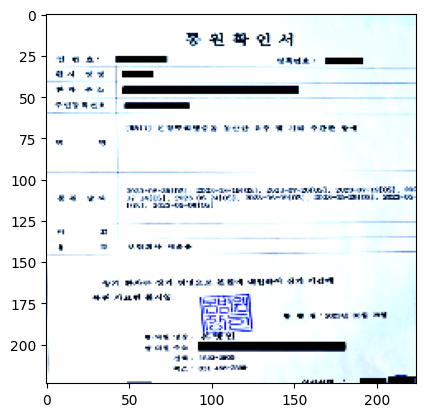

In [50]:
# 저장한 이미지 확인
plt.imshow(tst_img[134])
plt.show()

In [51]:
tst_df = pd.DataFrame({
    'img' : tst_img,
    'target' : tst_target_list,
    'predict' : tst_preds_list
})

In [55]:
len(tst_df['target'])

10519

In [52]:
# 맞춘 개수
(tst_df['predict'] == tst_df['target']).sum()

9643

In [53]:
# 틀린 개수
(~(tst_df['predict'] == tst_df['target'])).sum()

876

In [56]:
(~(tst_df['predict'] != tst_df['target'])).sum()/((tst_df['predict'] == tst_df['target']).sum()+(~(tst_df['predict'] == tst_df['target'])).sum())

0.9167221218747029

In [38]:
tst_df[~(tst_df['predict'] == tst_df['target'])]

,img,target,predict
29,"[[[0.67343086, 0.8879551, 1.1236601], [0.67343...",3,7
36,"[[[1.4611695, 1.6757703, 1.9776906], [1.444044...",7,3
43,"[[[0.5535576, 0.8179271, 1.2108061], [0.724805...",11,10
68,"[[[0.6220566, 1.0630251, 1.5942483], [0.604931...",7,3
70,"[[[-0.6622999, -0.26750696, 0.23477125], [-0.6...",7,3
...,...,...,...
14437,"[[[0.2589247, 1.0, 1.0], [0.2589247, 1.0, 1.0]...",11,16
14438,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",5,16
14440,"[[[0.0, 0.0, 0.5441721], [0.0, 0.0, 0.5441721]...",4,3
14441,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",9,16


In [57]:
i = pd.read_csv('../datasets_fin/test.csv')
i

,ID,target
0,02d404271e4965fa.jpg,15
1,03648b6855b9f8c1.jpg,10
2,0482c84f6e50fc44.jpg,5
3,05c521f2659c0711.jpg,16
4,0664699c12c8162c.jpg,11
...,...,...
152,e8e8dd06a96f2586.jpg,16
153,e985d6cb79c79810.jpg,4
154,ea379b41d59cec36.jpg,9
155,ebdb6f14d9876caa.jpg,8


In [58]:
# 각 예측의 이미지 id 추가
tst_df['ID'] = list(i['ID']) * 67

In [59]:
tst_df

,img,target,predict,ID
0,"[[[-0.045808766, 0.06512607, 0.25220045], [1.2...",15,15,02d404271e4965fa.jpg
1,"[[[1.1357992, 1.3256302, 1.5245316], [1.135799...",10,10,03648b6855b9f8c1.jpg
2,"[[[1.5981675, 2.0259104, 2.2914162], [1.563918...",5,5,0482c84f6e50fc44.jpg
3,"[[[0.15968828, 0.4152661, 0.77507627], [0.1596...",16,16,05c521f2659c0711.jpg
4,"[[[0.82755363, 0.7478991, 0.9842266], [0.26243...",11,11,0664699c12c8162c.jpg
...,...,...,...,...
10514,"[[[-1.5014129, -1.405462, -1.1769934], [-1.484...",16,16,e8e8dd06a96f2586.jpg
10515,"[[[-0.49105236, -0.37254897, -0.148671], [-0.4...",4,4,e985d6cb79c79810.jpg
10516,"[[[-1.6041614, -1.5105041, -1.2815685], [-1.60...",9,9,ea379b41d59cec36.jpg
10517,"[[[0.9303022, 1.0805322, 1.297952], [0.9474269...",8,8,ebdb6f14d9876caa.jpg


In [60]:
def get_item(idx):
    image, target, predict, name = tst_df.loc[idx,]
    img = np.array(Image.open(os.path.join("../datasets_fin/train/", name)))

    # img = trn_transform(image=img)['image']
    return img, target, name, predict, image

In [61]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('target')

target
7     442
3     197
14    187
11     40
4       7
5       1
9       1
12      1
Name: count, dtype: int64

In [62]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('predict')

predict
3     461
7     181
4     128
14     42
10     41
12     18
13      2
1       1
5       1
9       1
Name: count, dtype: int64

In [47]:
qw = tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == 7)]
qw

,img,target,predict,ID
36,"[[[1.4611695, 1.6757703, 1.9776906], [1.444044...",7,3,2e939381a84d19cf.jpg
68,"[[[0.6220566, 1.0630251, 1.5942483], [0.604931...",7,3,4e5848a4ad483009.jpg
70,"[[[-0.6622999, -0.26750696, 0.23477125], [-0.6...",7,3,4f1a0debe89c7641.jpg
99,"[[[-0.54242665, 0.10014007, 0.844793], [-0.730...",7,3,a376fbdb67bc4a92.jpg
100,"[[[0.9303022, 1.1330532, 1.4373856], [0.998801...",7,4,aac6d02aa2f222af.jpg
...,...,...,...,...
14286,"[[[1.0102177, 1.1972455, 1.3967174], [1.010217...",7,3,f9bfe5eae7d723ce.jpg
14310,"[[[0.0, 0.0, 0.094373226], [0.0, 0.0, 0.094373...",7,3,1e5bf6fe5e8686d6.jpg
14323,"[[[0.7984081, 1.0, 1.0], [0.7984081, 1.0, 1.0]...",7,3,2e939381a84d19cf.jpg
14355,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.4450237...",7,3,4e5848a4ad483009.jpg


In [48]:
qw.value_counts('predict')

predict
3     362
4      41
2      22
13     18
10      7
12      6
14      6
16      5
1       4
15      1
Name: count, dtype: int64

In [1]:
# # target과 predict가 일치하지 않는 이미지 시각화, target별로 확인
# check_target = 7
# for idx in tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == check_target)].index:
#     img, target, name, predict, image = get_item(idx)
#     print(img.shape, name, target, predict)
#     # plt.imshow(img) #원본 이미지
#     # plt.show()
#     plt.imshow(image) #학습에 사용된 이미지
#     plt.show()
#     # print(idx)

In [112]:
qw = tst_df[tst_df['target'] == 13]
qw

,img,target,predict,ID
17,"[[[-1.6555356, -1.545518, -1.4035729], [-1.724...",13,13,149c8444ae80d630.jpg
28,"[[[1.7522904, 1.9558823, 2.1519825], [1.735165...",13,13,233685659ef1ed84.jpg
81,"[[[0.108314015, 0.3452381, 0.56592596], [0.142...",13,13,590a4befbe2db3cc.jpg
83,"[[[0.36518532, 0.80042017, 1.1585186], [0.3823...",13,13,5be46f4d1470b120.jpg
96,"[[[0.8618032, 1.1330532, 1.4896731], [0.878927...",13,13,81e5282c3c19a13b.jpg
...,...,...,...,...
14368,"[[[0.0, 0.80398476, 0.7526777], [0.0, 0.803984...",13,7,590a4befbe2db3cc.jpg
14370,"[[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.1174487...",13,12,5be46f4d1470b120.jpg
14383,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.5157264...",13,13,81e5282c3c19a13b.jpg
14392,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",13,7,b0ab48967aaabefe.jpg


In [111]:
(qw['predict'] != qw['target']).sum()

126